## Complex Networks
* This file explores complex networks (i.e. Resnet, LSTM)
* Resnet credits to: https://github.com/fanzhenya/ResNet1D-VariableLengthPooling-For-TimeSeries

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, models, transforms
#from sklearn.metrics import precision_recall_curve

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
lambda_val = 3

In [3]:
# Biological features
# kd hydrophobicity scale
hydrophobicity = {'G': -0.4, 'A': 1.8, 'L':3.8, 'M': 1.9, 'F':2.8, 'W':-0.9, 'K':-3.9, 'Q':-3.5, 'E':-3.5, 'S':-0.8, 'P':-1.6, 'V':4.2, 'I':4.5, 'C':2.5, 'Y':-1.3, 'H':-3.2, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'T':-0.7}
# Ranked
polarity = {'A': 0.45, 'R': 0.75, 'N': 0.8, 'D': 0.95, 'C':0.35, 'Q': 0.85, 'E': 0.90, 'G': 0.55, 'H': 0.5, 'I': 0.05, 'L': 0.15, 'K': 1, 'M': 0.25, 'F': 0.1, 'P': 0.65, 'S': 0.7, 'T': 0.6, 'W': 0.3, 'Y': 0.4, 'V': 0.2}
# Van der waal's volume
volume = {'A': 67, 'R': 148, 'N': 96, 'D': 91, 'C':86, 'Q': 114, 'E': 109, 'G': 48, 'H': 118, 'I': 124, 'L': 124, 'K': 135, 'M': 124, 'F': 135, 'P': 90, 'S': 73, 'T': 93, 'W':163, 'Y':141, 'V': 105}

# TODO: branched, hydrophilic, hydrophobic, shape
charge = {'A': 2, 'R': 3, 'N': 2, 'D': 1, 'C': 2, 'E':1, 'Q':2, 'G':2, 'H': 3, 'I':2, 'L': 2, 'K': 3, 'M':2, 'F':2, 'P':2, 'S':2, 'T': 2, 'W':2, 'Y': 2, 'V':2 }

# Normalize all of the biological features:
# Charge
for k,v in charge.items():
    if v == 1:
        charge[k] = 0
    elif v == 2:
        charge[k] = 0.5
    else:
        charge[k] = 1.0

# Volume
for k,v in volume.items():
    volume[k] = v/163.0

#Polarity
min_v = -4.5
max_v = 4.5
for k,v in hydrophobicity.items():
    hydrophobicity[k] = (v - min_v)/(max_v - min_v)    

In [4]:
# Experiment with the blosum62 matrix
blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        blosum62[aa] = encoding

## Dataset

In [5]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [6]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [7]:
binary_ds=BinaryDataset(filepath="../data/higher_quality_data.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

## NN Model

In [8]:
# Expects aptamer directly translated
# Expects peptides with 4 biological features (hydrophobicity, polarity, volume, charge)
class BioNet(nn.Module):
    def __init__(self):
        super(BioNet, self).__init__()
        self.name = "BioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 20)
        self.fc2 = nn.Linear(20, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Expects aptamers directly translated
# Expects peptides directly translated + 4 biological features (hydrophobicity, polarity, volume, charge)
class TranslateBioNet(nn.Module):
    def __init__(self):
        super(TranslateBioNet, self).__init__()
        self.name = "TranslateBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(5, 30, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(30, 75, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(75, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 250, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(250, 100, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(100, 50, 3, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     self.cnn_pep_3, self.maxpool, self.relu,
                                     self.cnn_pep_4, self.maxpool, self.relu,
                                     self.cnn_pep_5, self.maxpool, self.relu,
                                     self.cnn_pep_6, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(115, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Expects aptamers directly translated
# Expects 4 biological features (hydrophobicity, polarity, volume, charge)
class ComplexBioNet(nn.Module):
    def __init__(self):
        super(ComplexBioNet, self).__init__()
        self.name = "ComplexBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 15)
        self.fc2 = nn.Linear(15, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x



In [9]:
# Expects aptamer one-hot encoded
# Expects peptides with 4 biological features (hydrophobicity, polarity, volume, charge)
class OHBioNet(nn.Module):
    def __init__(self):
        super(OHBioNet, self).__init__()
        self.name = "OHBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 30, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(30, 10, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 20)
        self.fc2 = nn.Linear(20, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [10]:
# Expects aptamers directly translated
# Expects 4 biological features (hydrophobicity, polarity, volume, charge)
class LinearBioNet(nn.Module):
    def __init__(self):
        super(LinearBioNet, self).__init__()
        self.name = "LinearBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 20, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(20, 10, 3, padding=2) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 10, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(10, 7, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(131, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc3 = nn.Linear(75, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be directly translated
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(210, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc3 = nn.Linear(75, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [13]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                encoding.append(blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') 
        pep = blosum62_encoding(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 1, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Nonbinding Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Nonbinding Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Binding Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Binding Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [14]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [ ]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        #model.apply(weights_init) commented out b/c resnet already has initialization
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    # Used for precision recall for train set
    train_true_labels = []
    train_pred_scores = []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            # Train Example
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)                
            
            # Keep track of Train TP, FP, TN, FN
            lam = 1
            if label == 0.0:
                train_gen_scores.append(train_score.item())
                if train_score.item() < 0.5:
                    train_stats[1] += 1
                    train_correct += 1
                else:
                    lam = lambda_val
                    train_stats[2] += 1
            elif label == 1.0:
                train_scores.append(train_score.item())
                if train_score.item() >= 0.5:
                    train_correct += 1
                    train_stats[0] += 1
                else:
                    train_stats[3] += 1
                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            # Val example
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            
            # Keep track of Val TP, FP, TN, FN
            lam = 1
            # The original label is nonbinding
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
                # The score is nonbinding: TN
                if val_score.item() < 0.5:
                    val_stats[1] += 1
                    val_correct += 1
                # The score is binding: FP
                else:
                    lam = lambda_val
                    val_stats[2] += 1
            # The original label is binding
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
                # The score is binding: TP
                if val_score.item() >= 0.5:
                    val_stats[0] += 1
                    val_correct += 1
                # The score is nonbinding: FN
                else:
                    val_stats[3] += 1

            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss
            
            # Calculate Val Loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            # Print Stats
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))
                print("Train: Sensitivity: " + str(train_stats[0]/(train_stats[0] + train_stats[3])) + " Specificity: " + str(train_stats[1]/(train_stats[2] + train_stats[1])))
                print("Val: Sensitivity: " + str(val_stats[0]/(val_stats[0] + val_stats[3])) + " Specificity: " + str(val_stats[1]/(val_stats[2] + val_stats[1])))
            # Plot Stats
            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                
                print("Training AUC at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation AUC epoch %d: {}".format(val_auc) % full_epoch)
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
        scheduler.step()
        # Save the weights
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

## Pretrained Network

In [16]:
def conv3x3(in_planes, out_planes, kernel_size=3, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                     padding=kernel_size//2, bias=True)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=1,
                               padding=kernel_size//2, bias=True)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class VariableLengthPooling(nn.Module):
    def forward(self, x, **kwargs):
        bounds = kwargs.get("bounds")
        # print("--------x--------", x.size(), x)
        # print("--------bounds--------", bounds.size(), bounds)
        cnt = torch.sum(bounds, dim=1)
        # print("--------cnt--------", cnt.size(), cnt)
        # print("--------bmm--------", torch.bmm(x, bounds).size(), torch.bmm(x, bounds))
        out = torch.bmm(x, bounds) / cnt
        # print("--------out--------", out.size(), out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "Resnet"
        self.single_alphabet=True
        self.inplanes = 192
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(48, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)

        self.conv_merge = nn.Conv1d(512 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, x, bounds=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        x = self.conv_merge(x)
        x = torch.squeeze(x, dim=2)
        x = x.view(1, -1)
        
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

class ResNetSeparated(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "ResnetSeparated"
        self.single_alphabet=False
        self.inplanes = 192
        super(ResNetSeparated, self).__init__()
        self.conv1_apt = nn.Conv1d(40, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv1_pep = nn.Conv1d(8, 192, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)
        
        self.apt_initial = nn.Sequential(self.conv1_apt, self.bn1, self.relu)
        self.pep_initial = nn.Sequential(self.conv1_pep, self.bn1, self.relu)
        
        

        self.conv_merge = nn.Conv1d(512 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        
        self.conv_layers = nn.Sequential(self.layer0, self.layer1, self.layer2, self.layer3, 
                                         self.layer4, self.layer5, self.conv_merge)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, apt, pep, bounds=None):
        apt = self.apt_initial(apt)
        pep = self.pep_initial(pep)
        
        apt = self.conv_layers(apt)
        pep = self.conv_layers(pep)
        
        apt = torch.squeeze(apt, dim=2)
        pep = torch.squeeze(pep, dim=2)
        
        apt = apt.view(1, -1)
        pep = pep.view(1, -1)
        
        x = torch.cat((apt, pep), 1)
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

<ipython-input-16-f8c99b2e0bb9>:210: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight.data)
  0%|          | 1/491198 [00:00<26:29:29,  5.15it/s]

Starting epoch: 0  with learning rate:  [0.0005]


 10%|█         | 49997/491198 [31:57<5:46:19, 21.23it/s] 

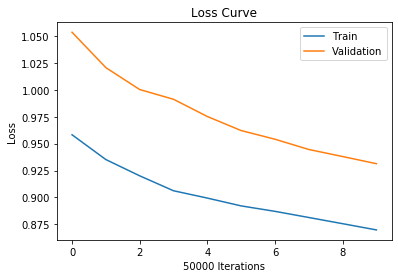

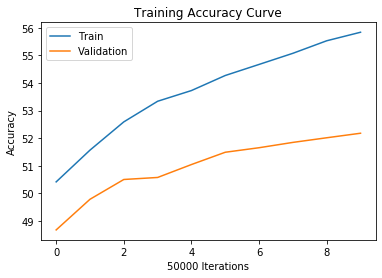

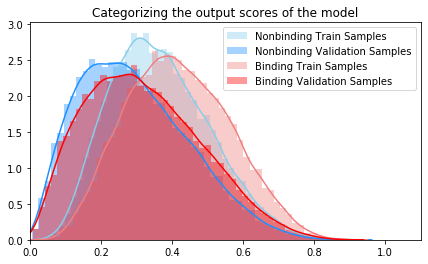

 10%|█         | 49997/491198 [32:10<5:46:19, 21.23it/s]

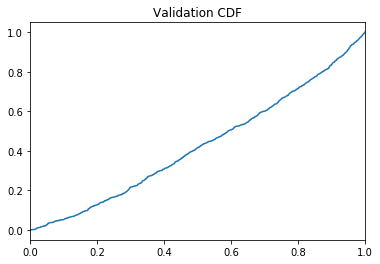

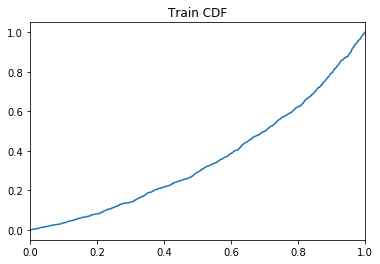

 10%|█         | 50004/491198 [32:55<496:32:54,  4.05s/it]

Training AUC at epoch 0: 0.35632836363636367
Validation AUC epoch 0: 0.4262242727272727
Training Accuracy at epoch 0: 55.84
Validation Accuracy epoch 0: 52.182


 20%|██        | 99996/491198 [1:04:57<3:20:53, 32.46it/s] 

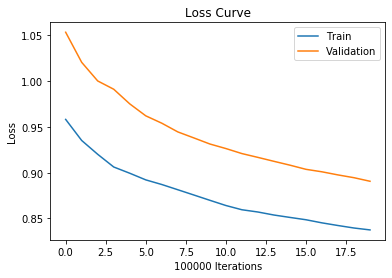

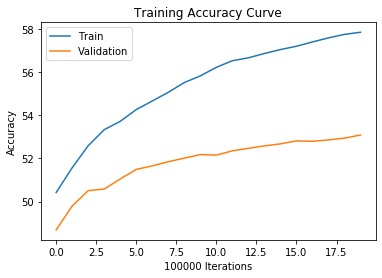

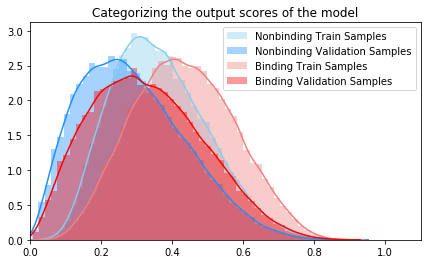

 20%|██        | 99996/491198 [1:05:10<3:20:53, 32.46it/s]

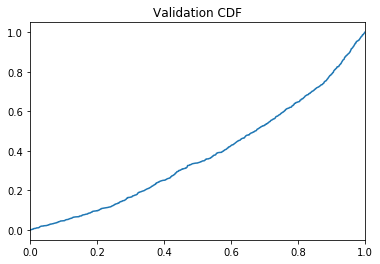

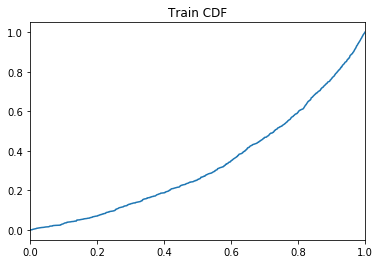

 20%|██        | 100004/491198 [1:05:55<334:09:51,  3.08s/it]

Training AUC at epoch 0: 0.3338659090909091
Validation AUC epoch 0: 0.37867663636363635
Training Accuracy at epoch 0: 57.869
Validation Accuracy epoch 0: 53.091


 31%|███       | 149999/491198 [1:38:17<2:32:59, 37.17it/s]  

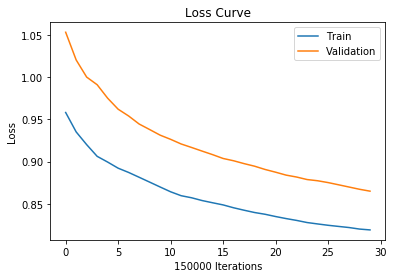

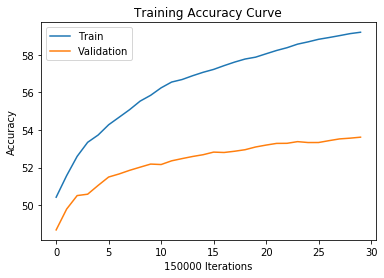

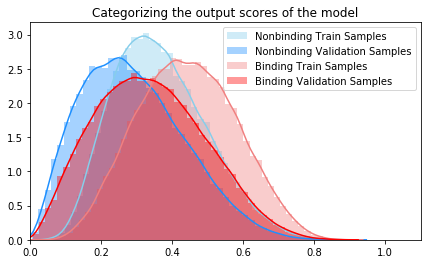

 31%|███       | 149999/491198 [1:38:31<2:32:59, 37.17it/s]

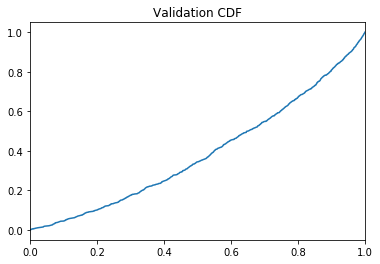

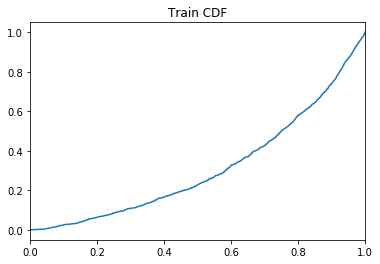

 31%|███       | 150004/491198 [1:39:17<1177:53:20, 12.43s/it]

Training AUC at epoch 0: 0.31272436363636363
Validation AUC epoch 0: 0.3870998181818182
Training Accuracy at epoch 0: 59.19466666666667
Validation Accuracy epoch 0: 53.61266666666667


 41%|████      | 199995/491198 [2:10:48<2:02:23, 39.66it/s]   

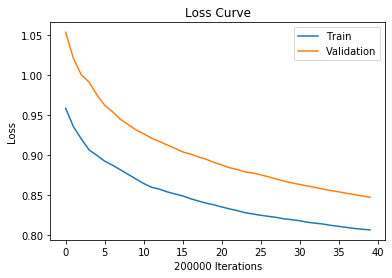

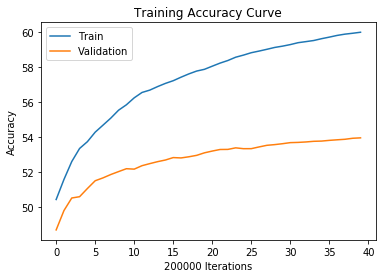

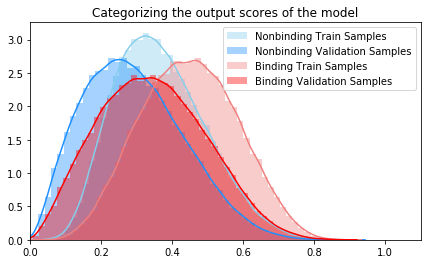

 41%|████      | 199995/491198 [2:11:01<2:02:23, 39.66it/s]

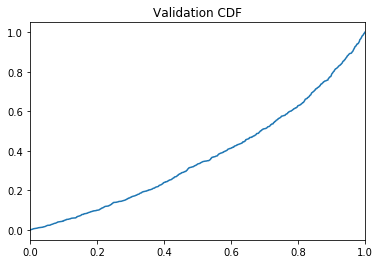

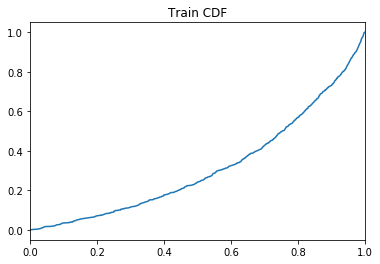

 41%|████      | 200004/491198 [2:11:48<203:29:49,  2.52s/it]

Training AUC at epoch 0: 0.31659354545454543
Validation AUC epoch 0: 0.37033527272727274
Training Accuracy at epoch 0: 59.9905
Validation Accuracy epoch 0: 53.9475


 51%|█████     | 249996/491198 [2:43:35<3:21:51, 19.92it/s]  

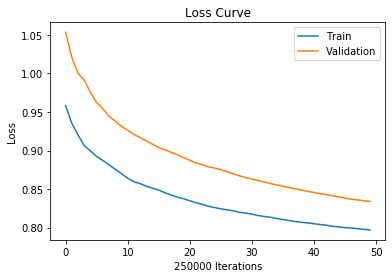

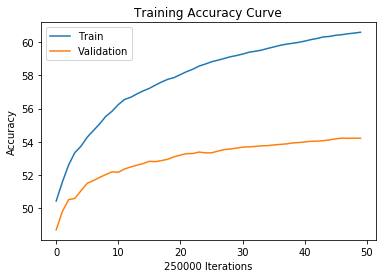

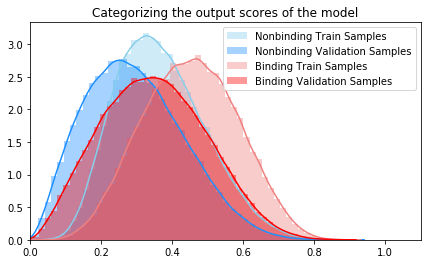

 51%|█████     | 249996/491198 [2:43:52<3:21:51, 19.92it/s]

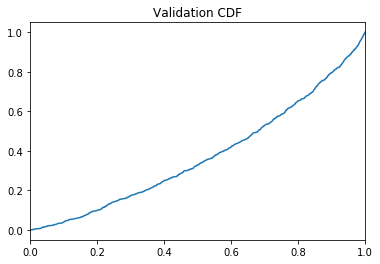

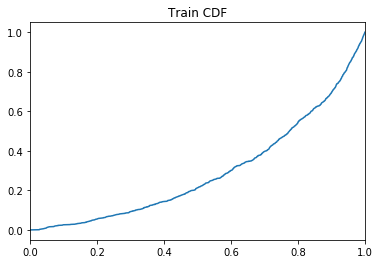

 51%|█████     | 250004/491198 [2:44:34<209:11:23,  3.12s/it]

Training AUC at epoch 0: 0.2931016363636364
Validation AUC epoch 0: 0.37452972727272726
Training Accuracy at epoch 0: 60.6028
Validation Accuracy epoch 0: 54.2056


 61%|██████    | 299997/491198 [3:16:44<1:37:14, 32.77it/s]  

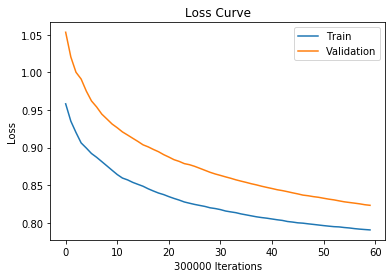

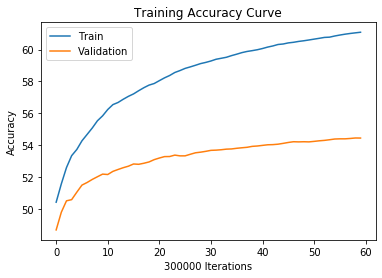

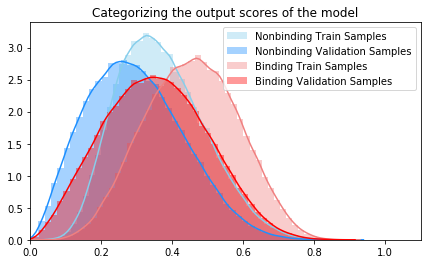

 61%|██████    | 299997/491198 [3:17:02<1:37:14, 32.77it/s]

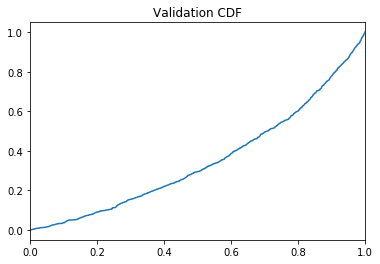

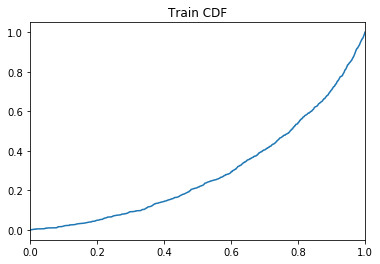

 61%|██████    | 300004/491198 [3:17:43<221:11:45,  4.16s/it]

Training AUC at epoch 0: 0.29346945454545453
Validation AUC epoch 0: 0.3523990909090909
Training Accuracy at epoch 0: 61.088
Validation Accuracy epoch 0: 54.446


 71%|███████▏  | 349995/491198 [3:49:49<1:03:56, 36.80it/s]  

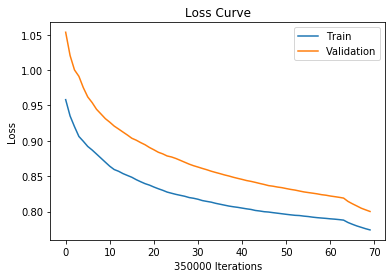

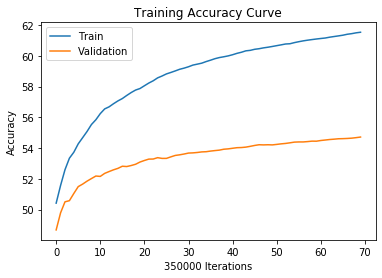

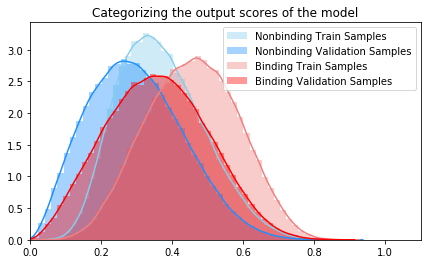

 71%|███████▏  | 349995/491198 [3:50:03<1:03:56, 36.80it/s]

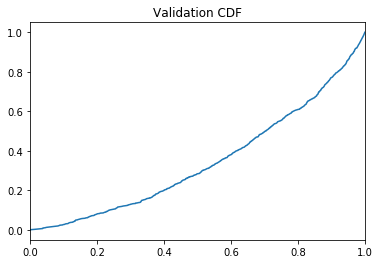

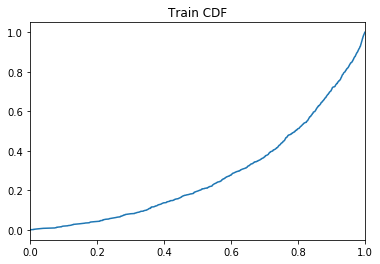

 71%|███████▏  | 350004/491198 [3:50:49<98:47:32,  2.52s/it] 

Training AUC at epoch 0: 0.2804515454545455
Validation AUC epoch 0: 0.34494136363636363
Training Accuracy at epoch 0: 61.527142857142856
Validation Accuracy epoch 0: 54.715428571428575


 81%|████████▏ | 399995/491198 [4:22:34<38:13, 39.76it/s]   

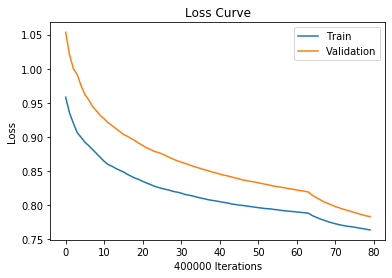

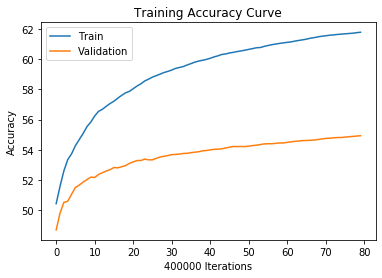

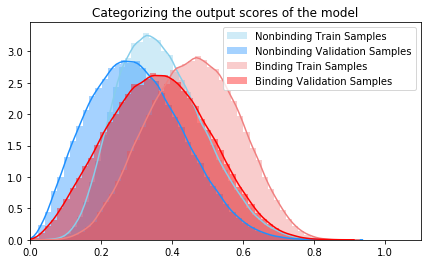

 81%|████████▏ | 399995/491198 [4:22:54<38:13, 39.76it/s]

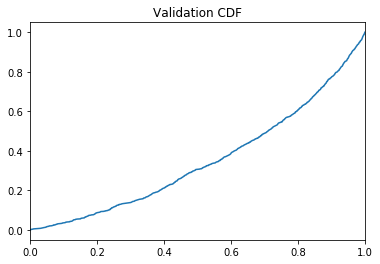

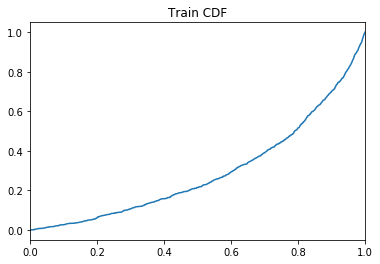

 81%|████████▏ | 400004/491198 [4:23:35<64:52:10,  2.56s/it]

Training AUC at epoch 0: 0.29339672727272725
Validation AUC epoch 0: 0.3510885454545455
Training Accuracy at epoch 0: 61.7915
Validation Accuracy epoch 0: 54.9265


 92%|█████████▏| 449998/491198 [4:54:49<28:57, 23.71it/s]   

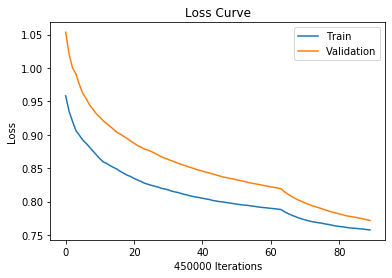

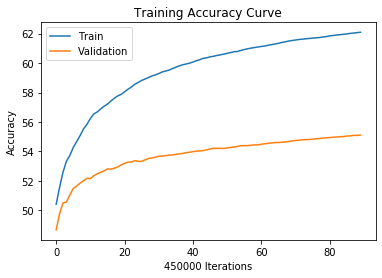

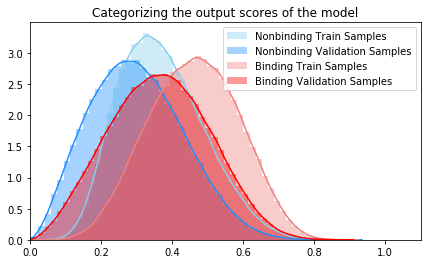

 92%|█████████▏| 449998/491198 [4:55:04<28:57, 23.71it/s]

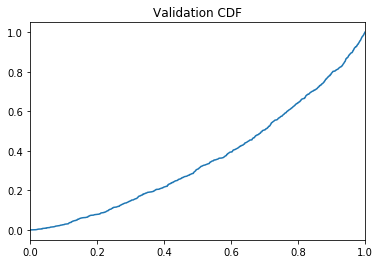

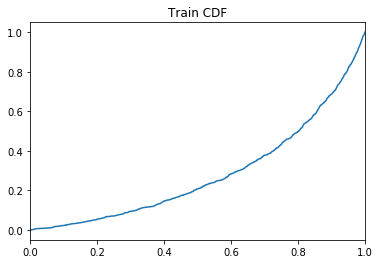

 92%|█████████▏| 450004/491198 [4:55:49<72:14:45,  6.31s/it] 

Training AUC at epoch 0: 0.2826460909090909
Validation AUC epoch 0: 0.3589176363636363
Training Accuracy at epoch 0: 62.086888888888886
Validation Accuracy epoch 0: 55.11377777777778


  0%|          | 0/491198 [00:00<?, ?it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/07292020.pth
Starting epoch: 1  with learning rate:  [0.0005]


  2%|▏         | 8799/491198 [05:28<4:05:56, 32.69it/s] 

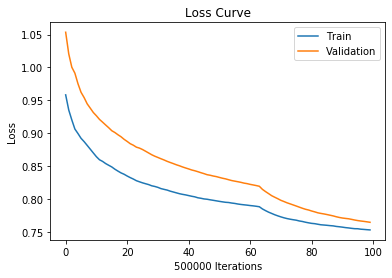

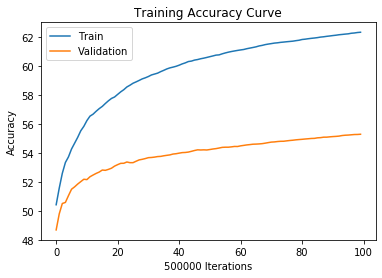

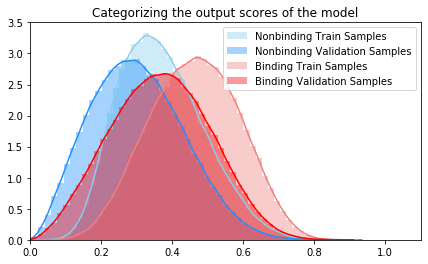

  2%|▏         | 8799/491198 [05:40<4:05:56, 32.69it/s]

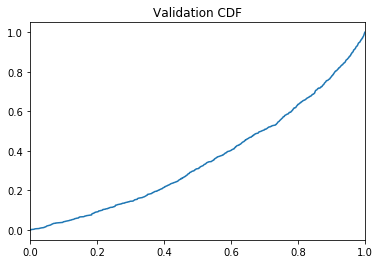

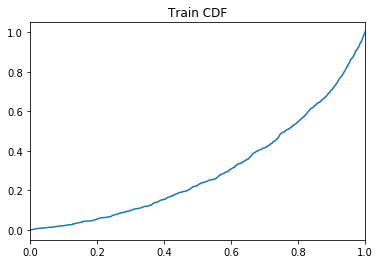

  2%|▏         | 8806/491198 [06:29<568:53:30,  4.25s/it]

Training AUC at epoch 1: 0.30119636363636365
Validation AUC epoch 1: 0.35966336363636364
Training Accuracy at epoch 1: 62.3442
Validation Accuracy epoch 1: 55.2934


 12%|█▏        | 58798/491198 [38:39<3:16:58, 36.59it/s] 

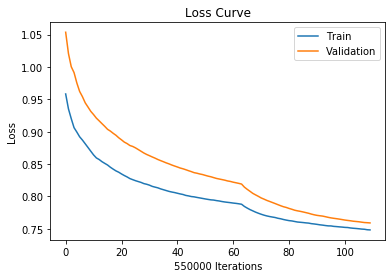

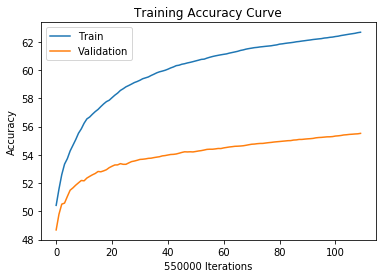

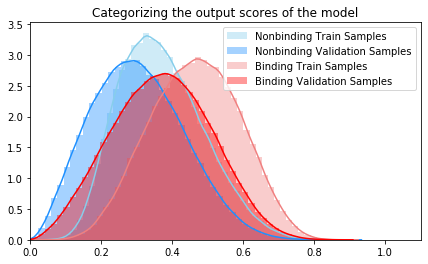

 12%|█▏        | 58798/491198 [38:50<3:16:58, 36.59it/s]

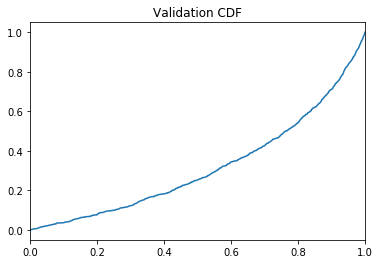

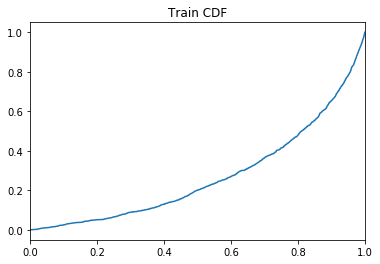

 12%|█▏        | 58805/491198 [39:40<388:16:00,  3.23s/it]

Training AUC at epoch 1: 0.27104390909090914
Validation AUC epoch 1: 0.3178997272727273
Training Accuracy at epoch 1: 62.686
Validation Accuracy epoch 1: 55.52072727272727


 22%|██▏       | 108798/491198 [1:11:51<2:43:47, 38.91it/s] 

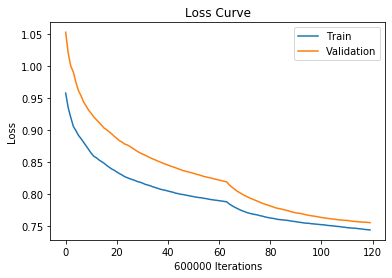

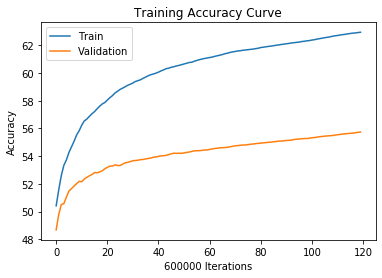

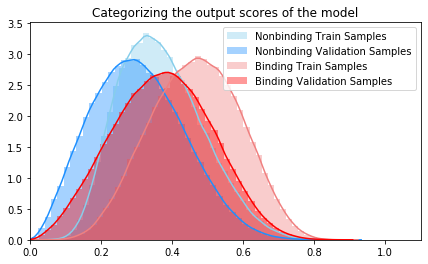

 22%|██▏       | 108798/491198 [1:12:11<2:43:47, 38.91it/s]

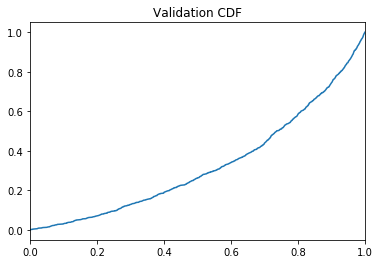

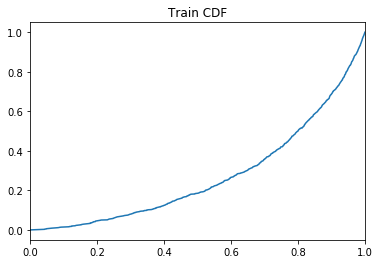

 22%|██▏       | 108806/491198 [1:12:53<346:39:52,  3.26s/it]

Training AUC at epoch 1: 0.2717105454545454
Validation AUC epoch 1: 0.326902
Training Accuracy at epoch 1: 62.9455
Validation Accuracy epoch 1: 55.7405


 32%|███▏      | 158801/491198 [1:44:40<4:33:03, 20.29it/s]  

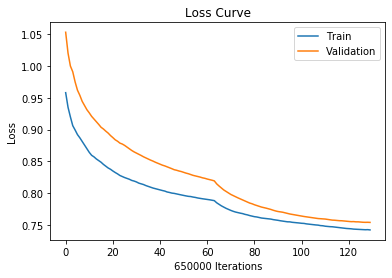

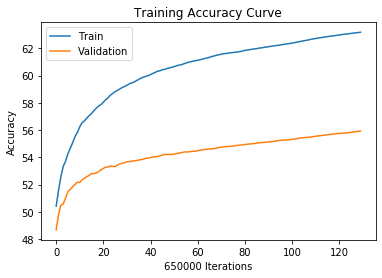

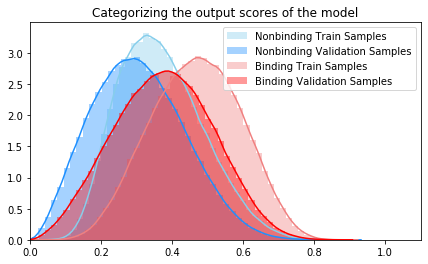

 32%|███▏      | 158801/491198 [1:44:51<4:33:03, 20.29it/s]

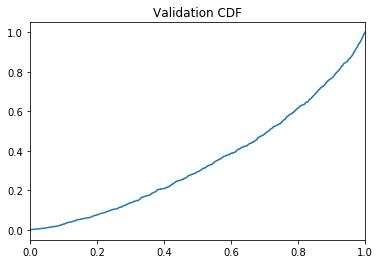

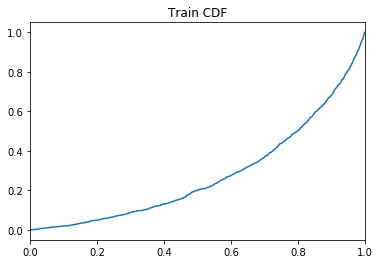

 32%|███▏      | 158806/491198 [1:45:41<1186:23:57, 12.85s/it]

Training AUC at epoch 1: 0.2780453636363637
Validation AUC epoch 1: 0.3476729090909091
Training Accuracy at epoch 1: 63.17261538461538
Validation Accuracy epoch 1: 55.918461538461536


 43%|████▎     | 208801/491198 [2:18:36<2:20:28, 33.50it/s]   

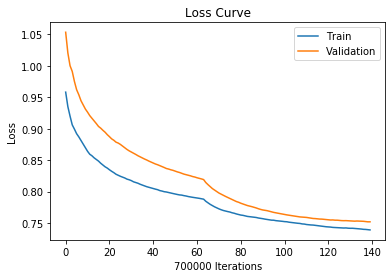

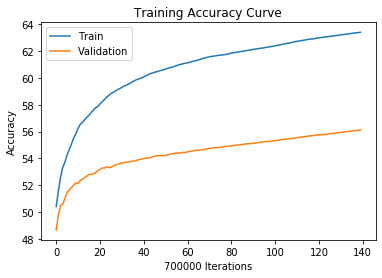

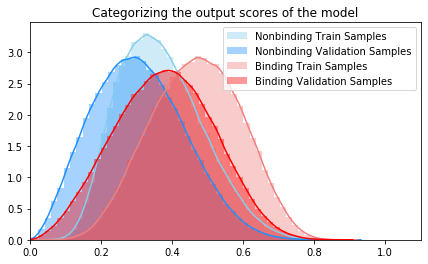

 43%|████▎     | 208801/491198 [2:18:52<2:20:28, 33.50it/s]

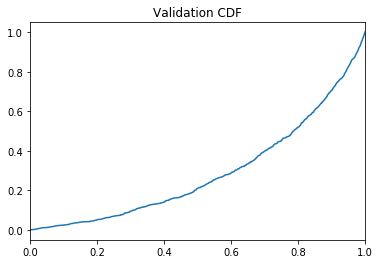

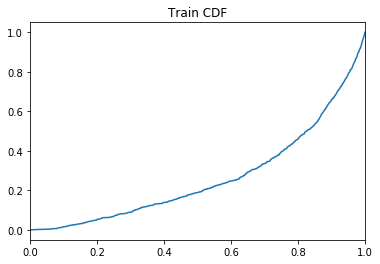

 43%|████▎     | 208806/491198 [2:19:39<1040:35:20, 13.27s/it]

Training AUC at epoch 1: 0.2637915454545454
Validation AUC epoch 1: 0.28937018181818186
Training Accuracy at epoch 1: 63.39257142857143
Validation Accuracy epoch 1: 56.12242857142857


 53%|█████▎    | 258800/491198 [2:52:18<1:46:28, 36.38it/s]   

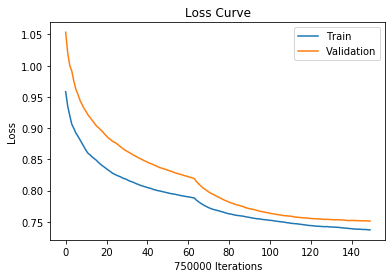

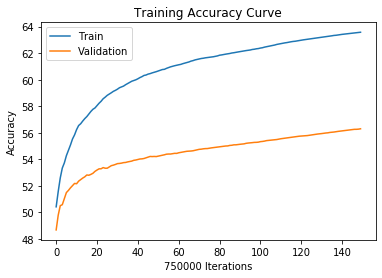

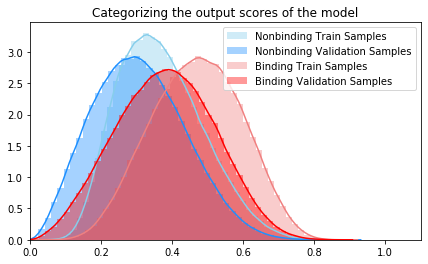

 53%|█████▎    | 258800/491198 [2:52:32<1:46:28, 36.38it/s]

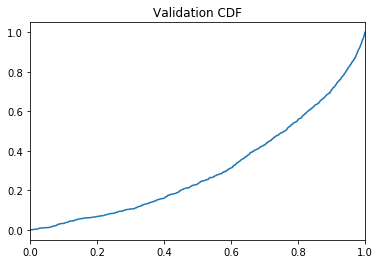

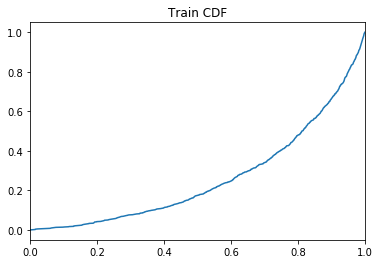

 53%|█████▎    | 258806/491198 [2:53:21<428:00:41,  6.63s/it]

Training AUC at epoch 1: 0.26124009090909095
Validation AUC epoch 1: 0.3083522727272727
Training Accuracy at epoch 1: 63.5732
Validation Accuracy epoch 1: 56.2992


 63%|██████▎   | 308797/491198 [3:24:51<1:15:07, 40.47it/s]  

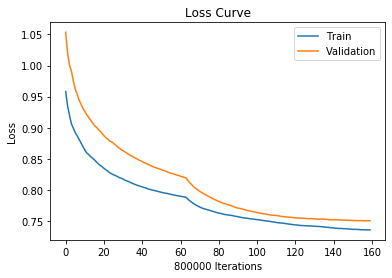

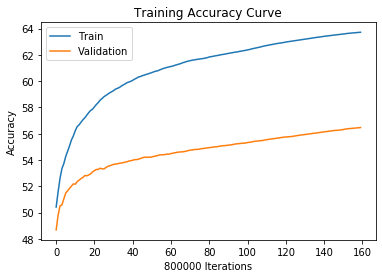

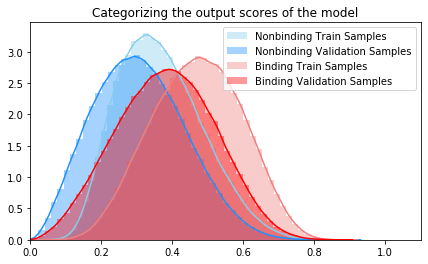

 63%|██████▎   | 308797/491198 [3:25:03<1:15:07, 40.47it/s]

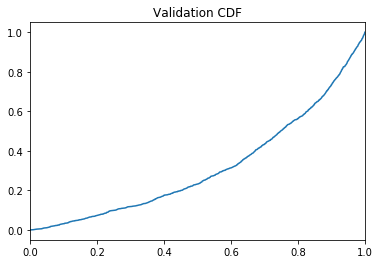

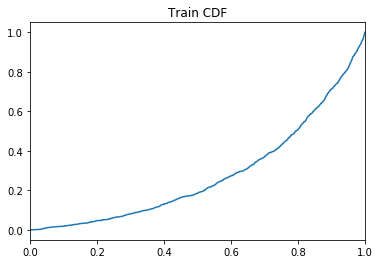

 63%|██████▎   | 308806/491198 [3:25:53<133:51:19,  2.64s/it]

Training AUC at epoch 1: 0.27886245454545455
Validation AUC epoch 1: 0.31536254545454545
Training Accuracy at epoch 1: 63.72275
Validation Accuracy epoch 1: 56.469125


 65%|██████▌   | 321005/491198 [3:33:26<1:16:16, 37.19it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 358799/491198 [3:56:37<1:47:18, 20.56it/s]

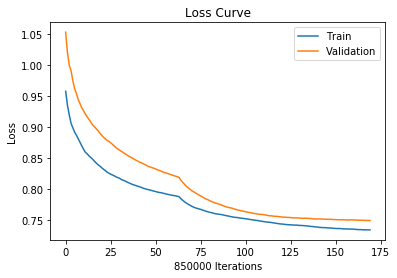

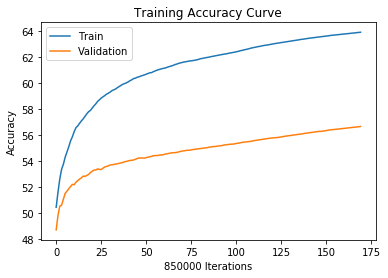

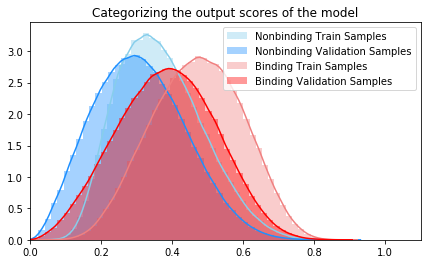

 73%|███████▎  | 358799/491198 [3:56:53<1:47:18, 20.56it/s]

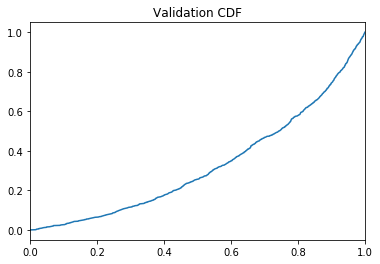

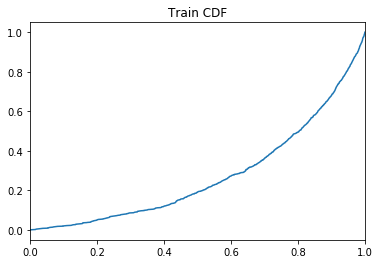

 73%|███████▎  | 358806/491198 [3:57:40<164:06:05,  4.46s/it]

Training AUC at epoch 1: 0.27417936363636364
Validation AUC epoch 1: 0.32549263636363635
Training Accuracy at epoch 1: 63.882823529411766
Validation Accuracy epoch 1: 56.63470588235294


 75%|███████▍  | 366264/491198 [4:02:16<52:02, 40.01it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 408799/491198 [4:28:23<43:02, 31.90it/s]  

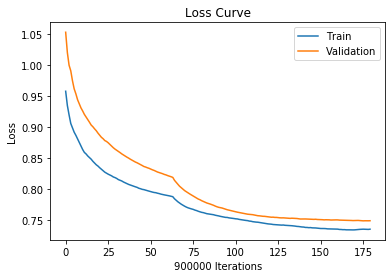

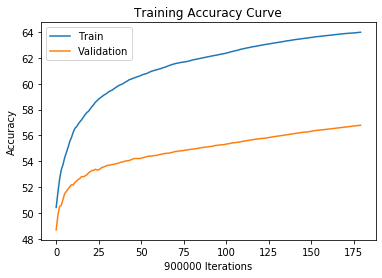

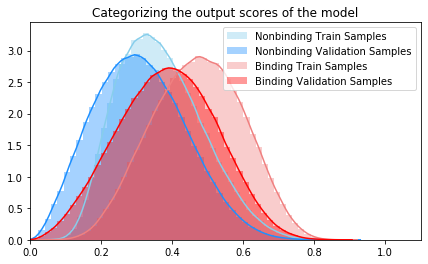

 83%|████████▎ | 408799/491198 [4:28:34<43:02, 31.90it/s]

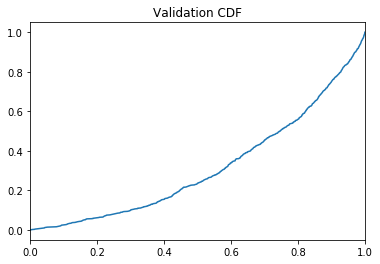

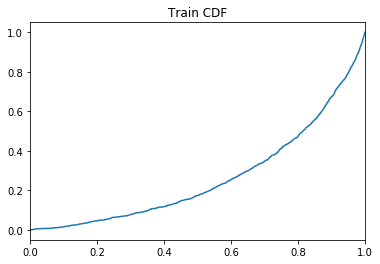

 83%|████████▎ | 408807/491198 [4:29:26<100:41:15,  4.40s/it]

Training AUC at epoch 1: 0.2638804545454545
Validation AUC epoch 1: 0.3148760909090909
Training Accuracy at epoch 1: 63.99422222222222
Validation Accuracy epoch 1: 56.788666666666664


 93%|█████████▎| 458797/491198 [4:59:49<14:16, 37.81it/s]    

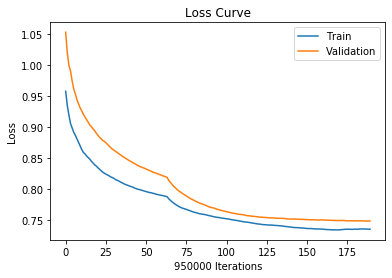

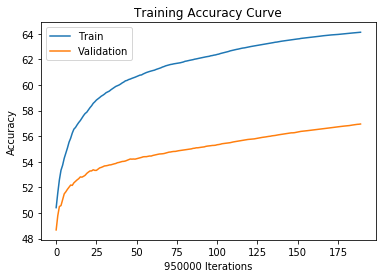

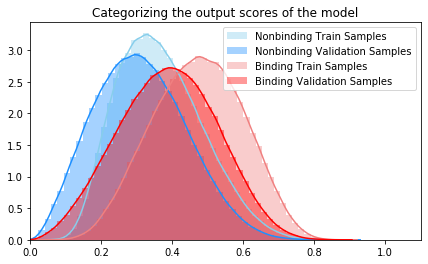

 93%|█████████▎| 458797/491198 [5:00:04<14:16, 37.81it/s]

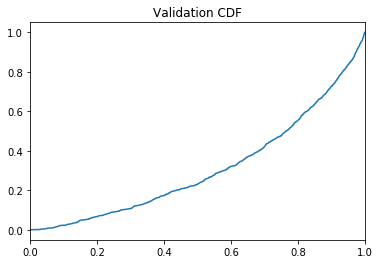

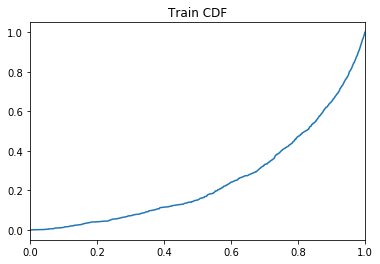

 93%|█████████▎| 458806/491198 [5:00:52<24:15:04,  2.70s/it]

Training AUC at epoch 1: 0.25296290909090907
Validation AUC epoch 1: 0.31030890909090914
Training Accuracy at epoch 1: 64.11252631578948
Validation Accuracy epoch 1: 56.94831578947368


  0%|          | 0/491198 [00:00<?, ?it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/07292020.pth
Starting epoch: 2  with learning rate:  [0.0005]


  2%|▏         | 9458/491198 [06:10<3:32:30, 37.78it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█▏        | 55300/491198 [35:46<8:56:57, 13.53it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 21%|██        | 101151/491198 [1:05:13<3:44:43, 28.93it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


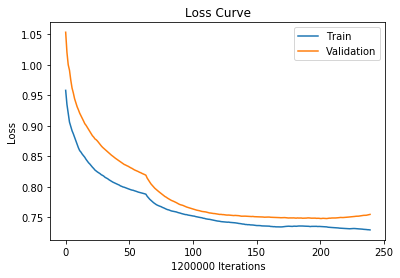

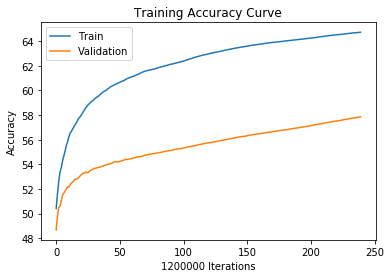

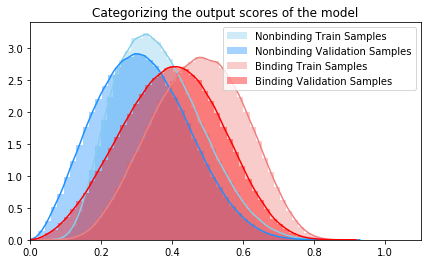

 44%|████▍     | 217602/491198 [2:22:11<1:50:57, 41.10it/s]

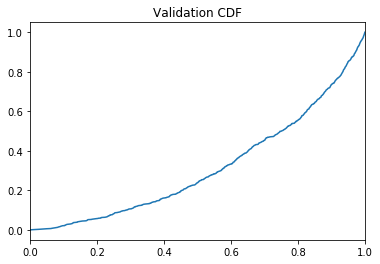

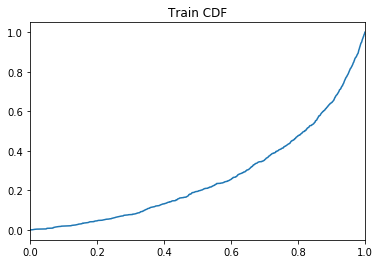

 44%|████▍     | 217608/491198 [2:23:01<526:02:08,  6.92s/it]

Training AUC at epoch 2: 0.26644999999999996
Validation AUC epoch 2: 0.3140988181818182
Training Accuracy at epoch 2: 64.716
Validation Accuracy epoch 2: 57.8525


 47%|████▋     | 231113/491198 [2:31:23<5:07:36, 14.09it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▍    | 267601/491198 [2:53:24<3:07:29, 19.88it/s]

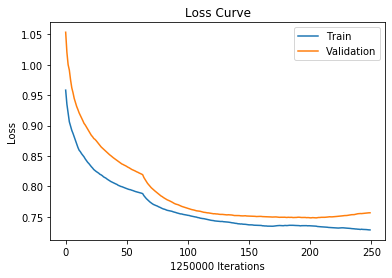

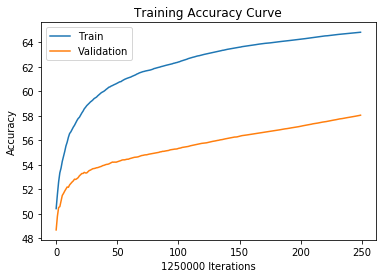

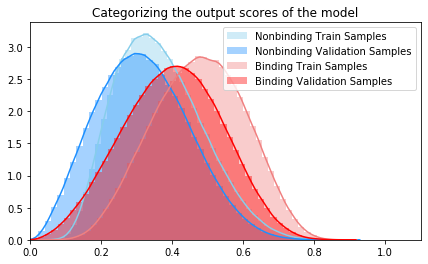

 54%|█████▍    | 267601/491198 [2:53:42<3:07:29, 19.88it/s]

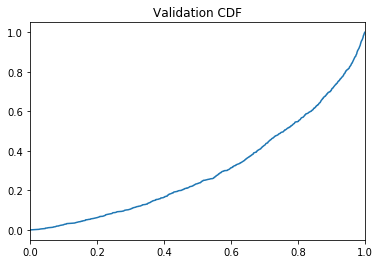

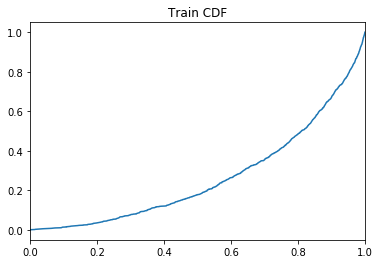

 54%|█████▍    | 267609/491198 [2:54:30<286:06:25,  4.61s/it]

Training AUC at epoch 2: 0.265744
Validation AUC epoch 2: 0.3060489090909091
Training Accuracy at epoch 2: 64.80928
Validation Accuracy epoch 2: 58.04056


 56%|█████▋    | 277365/491198 [3:00:27<1:31:09, 39.09it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 65%|██████▍   | 317603/491198 [3:24:55<1:24:25, 34.27it/s]

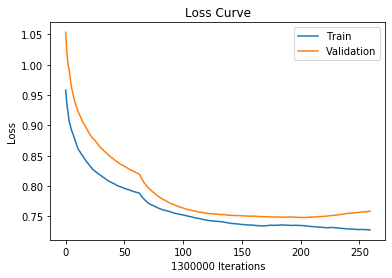

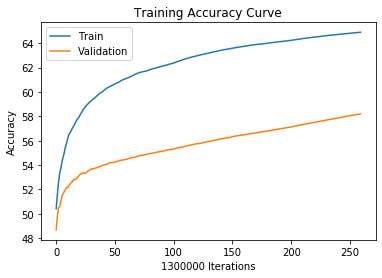

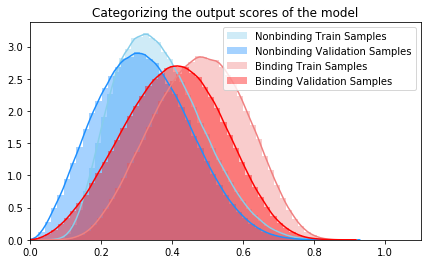

 65%|██████▍   | 317603/491198 [3:25:12<1:24:25, 34.27it/s]

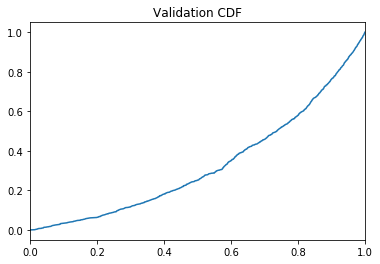

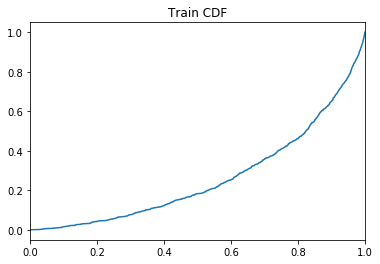

 65%|██████▍   | 317608/491198 [3:26:00<660:09:51, 13.69s/it]

Training AUC at epoch 2: 0.2627900909090909
Validation AUC epoch 2: 0.32839300000000005
Training Accuracy at epoch 2: 64.90046153846154
Validation Accuracy epoch 2: 58.19423076923077


 66%|██████▌   | 323165/491198 [3:29:24<1:29:41, 31.23it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 75%|███████▍  | 367600/491198 [3:56:23<52:07, 39.52it/s]  

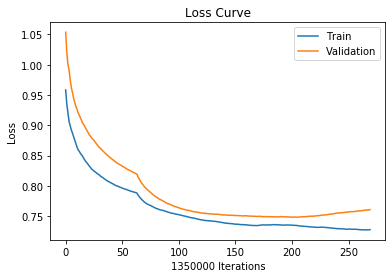

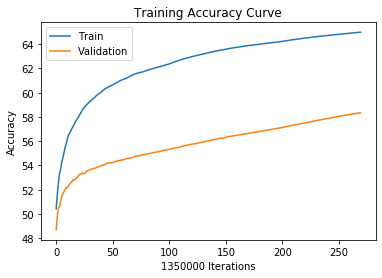

 75%|███████▍  | 367600/491198 [3:56:33<52:07, 39.52it/s]

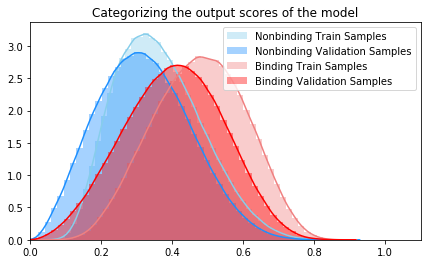

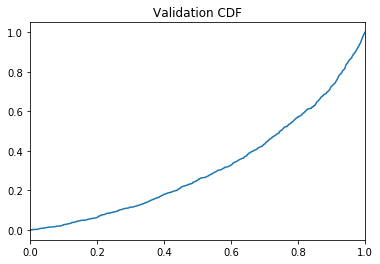

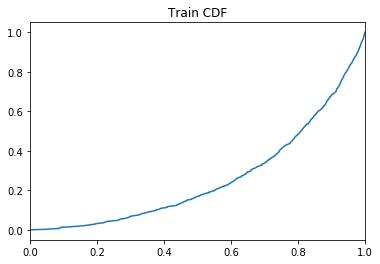

 75%|███████▍  | 367608/491198 [3:57:29<119:26:12,  3.48s/it]

Training AUC at epoch 2: 0.2596548181818182
Validation AUC epoch 2: 0.31692909090909094
Training Accuracy at epoch 2: 64.98814814814814
Validation Accuracy epoch 2: 58.352148148148146


 75%|███████▌  | 369589/491198 [3:58:41<52:30, 38.60it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 85%|████████▍ | 415379/491198 [4:26:23<1:00:58, 20.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 94%|█████████▍| 460971/491198 [4:55:17<13:30, 37.31it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config var

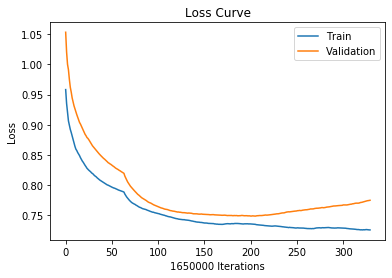

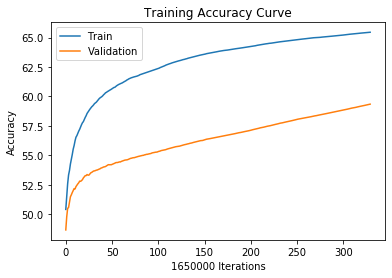

 36%|███▌      | 176405/491198 [1:51:42<3:30:32, 24.92it/s]

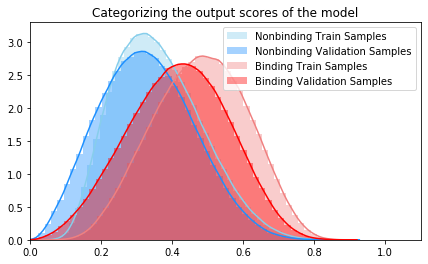

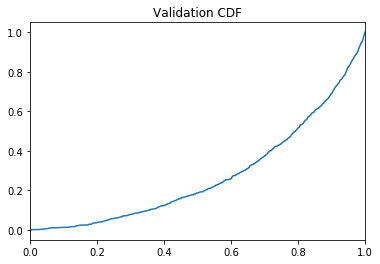

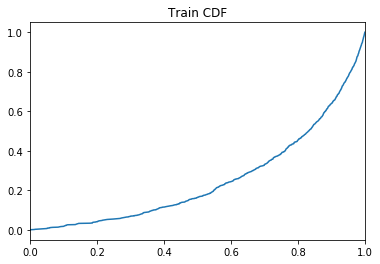

 36%|███▌      | 176410/491198 [1:52:40<1263:37:29, 14.45s/it]

Training AUC at epoch 3: 0.25335463636363637
Validation AUC epoch 3: 0.2748867272727273
Training Accuracy at epoch 3: 65.45042424242425
Validation Accuracy epoch 3: 59.350545454545454


 36%|███▌      | 177181/491198 [1:53:08<3:07:07, 27.97it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 222453/491198 [2:20:24<1:53:44, 39.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 55%|█████▍    | 268170/491198 [2:48:58<3:37:45, 17.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config va

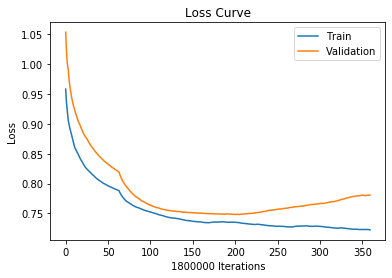

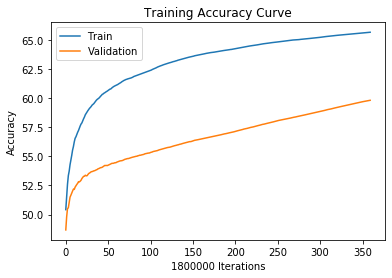

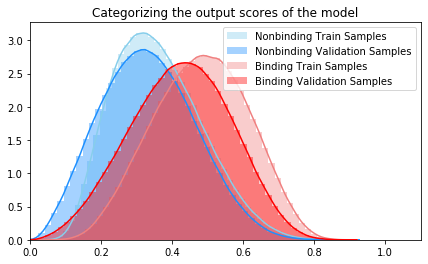

 66%|██████▋   | 326401/491198 [3:25:23<1:05:14, 42.10it/s]

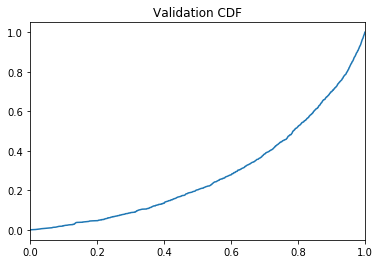

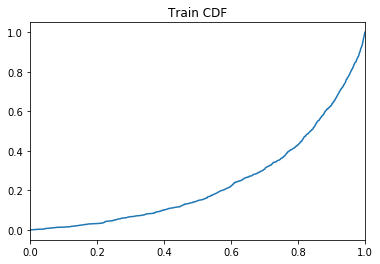

 66%|██████▋   | 326411/491198 [3:26:15<134:56:21,  2.95s/it]

Training AUC at epoch 3: 0.2414058181818182
Validation AUC epoch 3: 0.2839550909090909
Training Accuracy at epoch 3: 65.65044444444445
Validation Accuracy epoch 3: 59.807944444444445


 77%|███████▋  | 376403/491198 [3:56:39<1:31:42, 20.86it/s]  

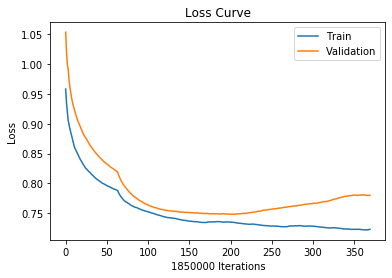

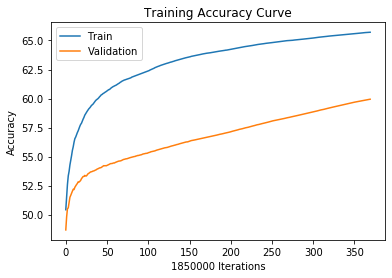

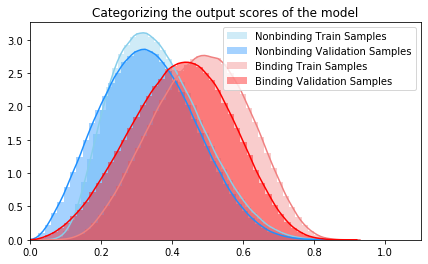

 77%|███████▋  | 376403/491198 [3:56:53<1:31:42, 20.86it/s]

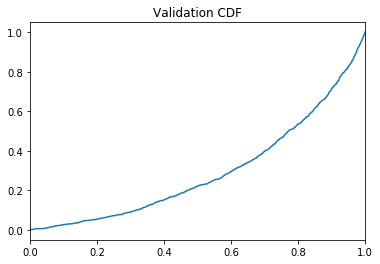

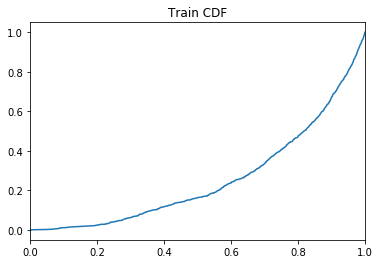

 77%|███████▋  | 376410/491198 [3:57:48<155:56:56,  4.89s/it]

Training AUC at epoch 3: 0.25492627272727275
Validation AUC epoch 3: 0.29439045454545454
Training Accuracy at epoch 3: 65.71081081081081
Validation Accuracy epoch 3: 59.940108108108106


 85%|████████▌ | 418644/491198 [4:23:36<50:29, 23.95it/s]    

In [ ]:
model=ResNetSeparated(BasicBlock, [2, 2, 1, 1], num_classes=2)
model_name = model.name
model_id = "07292020"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 50
BATCH_SIZE = 64
gamma = 1e-3
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path)